In [16]:
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [17]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya 
        self.xb, self.yb = xb, yb 
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) 
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        self.sigma = 0.0 
        self.vt = 0.0    
        self.cp = 0.0    

def define_panels(x, y, N):
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels

class Freestream:
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):

    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [18]:
x,y=numpy.loadtxt("naca0012.dat",dtype=float,unpack=True)
N_m,alpha=len(x)-1,0
R=3 #wing span(m)
omiga=5*2*numpy.pi  # angular velocity
u_inf=omiga*R
freestream = Freestream(u_inf,alpha)
panels = define_panels(x,y,N_m)
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-1]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [19]:
gamma

2.7775835003224971

In [20]:
def Vortex_point_initial(rv,psi,zeta,beta,miu,lamda):
    x=rv*numpy.cos(beta)*numpy.cos(psi-zeta)+miu*zeta
    y=rv*numpy.cos(beta)*numpy.sin(psi-zeta)
    z=rv*numpy.sin(beta)-lamda*zeta
    r=numpy.array([x,y,z])
    return r


In [21]:
N_j=12
N_k=12*3
N=12
R=50 #wing span(m)
omiga=5*2*numpy.pi  # angular velocity
rv=1
d_psi,d_zeta=numpy.pi*2/N,numpy.pi*2/N
psi=[[0 for j in range(N_j)]  for k in range(N_k+1)] 
lamda=0.1  # rotor inflow ratio, we can assume it is constant as the inflow is simplified as uniform inflow 
zeta=[[0 for j in range(N_j)]  for k in range(N_k+1)] 
miu=[[0 for j in range(N_j)]  for k in range(N_k+1)] 
beta=[[0 for j in range(N_j)]  for k in range(N_k+1)] 
## beta=miu=0 because we assume helicopter is hovering
for k in range(N_k+1):
    for j in range(N_j):
        psi[k][j]=j*d_psi

for k in range(N_k+1):
    for j in range(N_j):
        zeta[k][j]=k*d_psi

In [22]:
vortex_points= [[0 for j in range(N_j)]  for k in range(N_k+1)]
for k in range(N_k+1):
    for j in range(N_j):
        vortex_points[k][j]=Vortex_point_initial(rv,psi[k][j],zeta[k][j],beta[k][j],miu[k][j],lamda)

In [23]:
def induced_velocity(point,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i):
    v_induced=numpy.array([0,0,0])
    #calculate induced velocity at point(j,k)
    for a in range (N_k):
        for b in range (N_j):
            r1=point-vortex_points[a][b] # vector from  p(a,b) to p
            r2=point-vortex_points[a+1][b] # vector from  p(a,b+1) to p
            r1_value=numpy.sqrt(r1[0]**2+r1[1]**2+r1[2]**2)
            r2_value=numpy.sqrt(r2[0]**2+r2[1]**2+r2[2]**2)
            judge=r1_value*r2_value
            if judge!=0:  
                l=vortex_points[a+1][b]-vortex_points[a][b]  # one vortex line
                l_value=numpy.sqrt(l[0]**2+l[1]**2+l[2]**2)
                theta1=numpy.arccos(numpy.dot(l,r1)/l_value/r1_value)
                theta2=numpy.arccos(numpy.dot(l,r2)/l_value/r2_value)
                h=r1_value*numpy.sin(theta1)
                cross=numpy.cross(l,r1)
                e=cross/numpy.sqrt(cross[0]**2+cross[1]**2+cross[2]**2)
                rc=1.12*numpy.sqrt(4*(0.1*gamma+0.000146)*zeta_i/omiga) #radius of vortex core 
                v=gamma/4/numpy.pi*h/((rc**(2*n)+h**(2*n))**(1/n))*(numpy.cos(theta1)-numpy.cos(theta2))*e
                v_induced=v_induced+v
            elif judge==0:  # the point is at the vortex line
                v_induced=v_induced
    return v_induced
    

In [24]:
def vortex_points_iteration(vortex_points,gamma,zeta,omiga,d_psi,n,N_k,N_j):
    vortex_new=numpy.empty_like(vortex_points)
    for k in range (N_k):
        for j in range(N_j): 
            vortex_new[k][j]=vortex_points[k][j]
    for k in range (N_k):
        for j in range(N_j):
            a=k;b=j;c=k+1;d=j+1;
            if j==11:
                d=0 # periodic boundary condition
            i=k
            zeta_i=zeta[i][0]  # set the zeta_i
            point1=vortex_points[a][b]
            point2=vortex_points[c][b]
            point3=vortex_points[a][d]
            point4=vortex_points[c][d]
            v1=induced_velocity(point1,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i)
            v2=induced_velocity(point2,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i)
            v3=induced_velocity(point3,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i)
            v4=induced_velocity(point4,vortex_points,gamma,zeta_i,omiga,n,N_k,N_j,i)
            v=(v1+v2+v3+v4)/4
            if j<11:
                vortex_new[k+1][j+1]=vortex_points[k][j]+v/omiga*d_psi
            elif j==11:
                vortex_new[k+1][0]=vortex_points[k][j]+v/omiga*d_psi #periodic boundary condition
    return vortex_new

In [25]:
def wake_convergence_erro(n,N_k,N_j,vortex_points_1,vortex_points_2):
    erro=0
    for k in range(N_k):
        for j in range(N_j):
            deference=vortex_points_1[k][j]-vortex_points_2[k][j]
            erro=erro+numpy.sqrt(deference[0]**2+deference[1]**2+deference[2]**2)/N/N
    return erro


In [29]:
erro=0;m=2
n=1;
iteration=numpy.empty(100, dtype=object)
iteration[0]=vortex_points
while m>0:
    iteration[n]=vortex_points_iteration(iteration[n-1],gamma,zeta,omiga,d_psi,n,N_k,N_j)
    erro=wake_convergence_erro(n,N_k,N_j,iteration[n-1],iteration[n])
    m=m-1
    n=n+1
    
    

In [30]:
erro

0.45630279598784729

In [50]:
n

3

In [37]:
c=2
x=[];y=[];z=[];
for i in range (N_k):
    x=numpy.append(x,iteration[c][i][0][0])
    y=numpy.append(y,iteration[c][i][0][1])
    z=numpy.append(z,iteration[c][i][0][2])

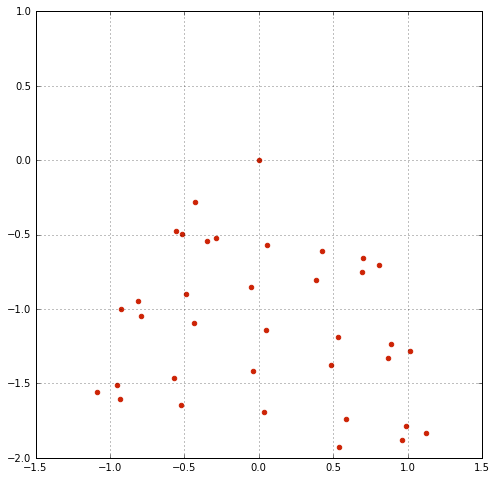

In [49]:
width = 8
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.scatter(y,z,color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-1.5, 1.5)
pyplot.ylim(-2, 1);

In [39]:
z

array([ 0.        , -0.27898794, -0.54545207, -0.47750625, -0.49309866,
       -0.52618839, -0.56661179, -0.61085878, -0.65728515, -0.70498453,
       -0.75340618, -0.80219373, -0.85110701, -0.89998   , -0.94869671,
       -0.99717657, -1.04536531, -1.0932293 , -1.14075204, -1.18793198,
       -1.2347813 , -1.28132486, -1.32759921, -1.37365099, -1.41953464,
       -1.4653094 , -1.51103597, -1.55677317, -1.60257507, -1.64848874,
       -1.69455244, -1.74079433, -1.7872314 , -1.8338688 , -1.88069959,
       -1.92770544])